In [1]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
from pytesseract import Output
from utils import convert_key_value_pairs
pytesseract.pytesseract.tesseract_cmd = r'E:\Downloads\Tesseract OCR\tesseract.exe'


     
        
       
   

   

GREEN FIELD
5305 E PACIFIC COAST HWY
Long Beach, CA 90804
(562) 597-0906

Server: Francis Station: 3

Order #: 69973 Dine In
Table: B11 Guests: 2

1 Coffee 3.00
2 Lunch 4s .90
1 Coke 3.00

 
      
    

SUB TOTAL: 51.90
Tax 1: U.68

TOL: 9

5/26/2016 12:53:10 PM

ean

   
      
  

THANK YOU!

    

<re.Match object; span=(47, 57), match='FIELD\n5305'>
Invoice number ('FIELD\n', '5305')
Date 5/26/2016
Items [('1', 'Coffee', '3.00'), ('', '4s', '.90'), ('1', 'Coke', '3.00')]


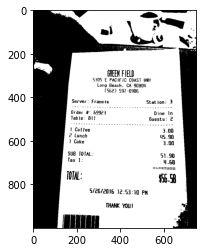

In [6]:

#path = str('E:/Nitin/RVCE/Projects/PDF-OCR/Dataset/receipts/1003-receipt.jpg')

path = 'E:\\Nitin\\RVCE\\Projects\\PDF-OCR\\Dataset\\receipts\\1000-receipt.jpg'
img = cv2.imread(path,0)

_, blackAndWhite = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
img = cv2.bilateralFilter(img, 20, 25, 25)
#img = cv2.GaussianBlur(blackAndWhite,(5,5),0)
cv2.imwrite('result.png',blackAndWhite)
plt.imshow(blackAndWhite,cmap='gray')
text = pytesseract.image_to_string(blackAndWhite) 
#print(text)
convert_key_value_pairs(text)